In [27]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import random
import seaborn as sns

import matplotlib.pyplot as plt

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


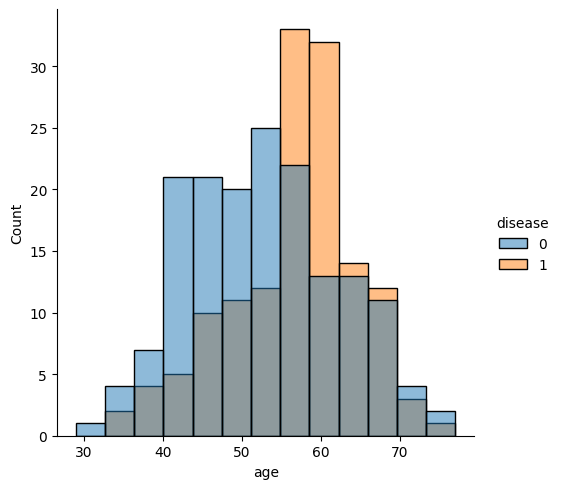

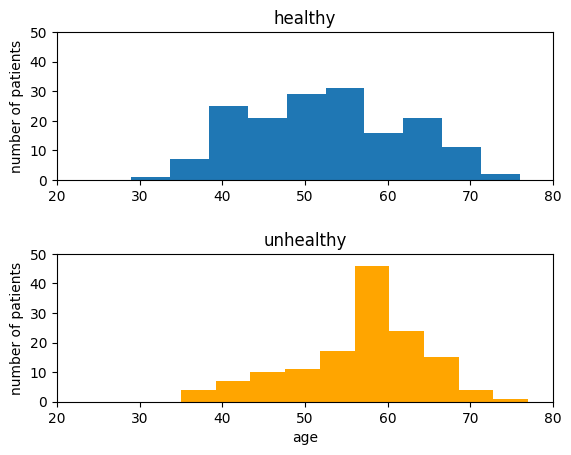

In [28]:
df = pd.read_csv('cleveland.csv')

df = df.rename({'num':'disease'}, axis=1)
df['disease'] = df.disease.apply(lambda x: min(x, 1))
display(df.head(5))
sns.displot(data=df, x='age', hue='disease')
# Plot histograms
fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

ax1.hist(df[df.disease == 0].age);
# ax1.set_xlabel('age');
ax1.set_ylabel('number of patients');
ax1.set_xlim(20, 80);
ax1.set_ylim(0, 50);
ax1.set_title('healthy');

ax2.hist(df[df.disease == 1].age, color='orange');
ax2.set_xlabel('age');
ax2.set_ylabel('number of patients');
ax2.set_xlim(20, 80);
ax2.set_ylim(0, 50);
ax2.set_title('unhealthy');


In [29]:
# Use knn on age. First create a nearest neighbors object.
nn = NearestNeighbors(n_neighbors=5, metric='euclidean', algorithm='auto')

# Create a two-dimensional array. This is basically a one-dimensional array with
# single-element arrays of patient ages in the second dimension. We're going to
# search for neighbors using only the age dimension.
X = [[x] for x in df.age]
X

# This builds an index data structure under the hood for query performance
fit = nn.fit(X)

# Find the k nearest neighbors
distances, indices = fit.kneighbors([[70]])
display(distances)
display(indices)
distances, indices

# Get the patients that are near the age
nbrs = df.iloc[indices[0]]
display(nbrs)

# Print how many patients are sick and how many are healthy
healthy = nbrs[nbrs.disease == 0].count().disease
sick = nbrs[nbrs.disease == 1].count().disease
print('healthy: {}\nsick: {}'.format(healthy, sick))

array([[0., 0., 0., 0., 1.]])

array([[258, 155, 170, 136, 189]], dtype=int64)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,disease
258,70.0,1.0,2.0,156.0,245.0,0.0,2.0,143.0,0.0,0.0,1.0,0.0,3.0,0
155,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
170,70.0,1.0,3.0,160.0,269.0,0.0,0.0,112.0,1.0,2.9,2.0,1.0,7.0,1
136,70.0,1.0,4.0,145.0,174.0,0.0,0.0,125.0,1.0,2.6,3.0,0.0,7.0,1
189,69.0,1.0,3.0,140.0,254.0,0.0,2.0,146.0,0.0,2.0,2.0,3.0,7.0,1


healthy: 1
sick: 4


In [30]:
from sklearn.metrics import precision_recall_fscore_support
# Standardize the data
df['age_s'] = (df.age - df.age.mean()) / df.age.std()
df['trestbps_s'] = (df.trestbps - df.trestbps.mean()) / df.trestbps.std()
df['chol_s'] = (df.chol - df.chol.mean()) / df.chol.std()
df['thalach_s'] = (df.thalach - df.thalach.mean()) / df.thalach.std()
df['cp_s'] = (df.cp - df.cp.mean()) / df.cp.std()
df['restecg_s'] = (df.restecg - df.restecg.mean()) / df.restecg.std()
df.trestbps_s

## From what I understand, the below is doing this:
## 1. getting all of the values and doing nn.fit(X) to do something cool
## 2. getting a sample of the data based on n
## 3. taking the sample, and grabbing the values for disease, age, etc, for each of them
## 4. We are then grabbing the k-nearest neighbors of each sample based on patientsX (age, trestbps, each of the patients data).
## 5. Predict all of them

# Use knn on age. First create a nearest neighbors object.

# Use knn on age. First create a nearest neighbors object.
nn = NearestNeighbors(n_neighbors=8, metric='euclidean', algorithm='auto')

age = 'age_s'
trestbps = 'trestbps_s'
chol = 'chol_s'
thalach = 'thalach_s'
cp = 'cp_s'
restecg = 'restecg_s'

# This builds an index data structure under the hood for query performance
X = df[[age, trestbps, chol,thalach,cp,restecg]].values
fit = nn.fit(X)

# Get random patients to test on
n = 10
patients = df.sample(n)
patientsX = patients[[age,trestbps,chol,thalach,cp,restecg]].values
patientsy = patients[['disease']].values
# display(patients)

# Find the k nearest neighbors to the patient.
distances, indices = fit.kneighbors(patientsX)
# print('indices of k-nearest neighbors for each patient:')
# display(indices)


f_scores = []
for j in range(10):
    y_pred = []
    n = 50
    patients = df.sample(n)
    patientsX = patients[[age,trestbps,chol,thalach,cp,restecg]].values
    patientsy = patients[['disease']].values
# display(patients)

# Find the k nearest neighbors to the patient.
    distances, indices = fit.kneighbors(patientsX)
    for i in range(n):
        # print('nearest neighbors to patient: {}:'.format(patientsX[i]))
        nbrs = df.iloc[indices[i]]
        # Drop the patient of interest
        nbrs = nbrs.drop(patients.index[i])
        # display(nbrs)
    
        healthy = nbrs[nbrs.disease == 0].count().disease
        sick = nbrs[nbrs.disease == 1].count().disease
        # print("Healthy: ", healthy)
        # print("Sick: ",sick)
        predict = 0 if (healthy > sick) else 1
        # print(f'healthy: {healthy}, sick: {sick}, predicted: {predict}, actual: {patientsy[i][0]}')
        y_pred.append(predict)

# This is where we would compile how many patients are predicted
# correctly. Remember:
#    precision = tp/(tp+fp)  ("sloppiness")
#    recall    = tp/(tp+fn)  ("What percentage did we find?")
#    f-score - a balance between precision and recall
#    support - number of positive labels
    (p,r,f,s) = precision_recall_fscore_support(patientsy, y_pred, labels=[0,1])
    f_scores.append(f[1])
    # display(y_pred)
    # display(patientsy)
    print(f'precision={p}, recall={r}, f-score={f}, support={s}')
    y_pred = []
    

display(f_scores)

precision=[0.84 0.72], recall=[0.75       0.81818182], f-score=[0.79245283 0.76595745], support=[28 22]
precision=[0.75862069 0.52380952], recall=[0.6875     0.61111111], f-score=[0.72131148 0.56410256], support=[32 18]
precision=[0.66666667 0.75      ], recall=[0.8 0.6], f-score=[0.72727273 0.66666667], support=[25 25]
precision=[0.59259259 0.73913043], recall=[0.72727273 0.60714286], f-score=[0.65306122 0.66666667], support=[22 28]
precision=[0.75 0.5 ], recall=[0.65625    0.61111111], f-score=[0.7  0.55], support=[32 18]
precision=[0.64516129 0.78947368], recall=[0.83333333 0.57692308], f-score=[0.72727273 0.66666667], support=[24 26]
precision=[0.7826087  0.66666667], recall=[0.66666667 0.7826087 ], f-score=[0.72 0.72], support=[27 23]
precision=[0.82142857 0.63636364], recall=[0.74193548 0.73684211], f-score=[0.77966102 0.68292683], support=[31 19]
precision=[0.55555556 0.82608696], recall=[0.78947368 0.61290323], f-score=[0.65217391 0.7037037 ], support=[19 31]
precision=[0.7  0.

[0.7659574468085106,
 0.5641025641025641,
 0.6666666666666666,
 0.6666666666666666,
 0.55,
 0.6666666666666666,
 0.72,
 0.6829268292682927,
 0.7037037037037037,
 0.6818181818181818]

Text(0, 0.5, 'f score')

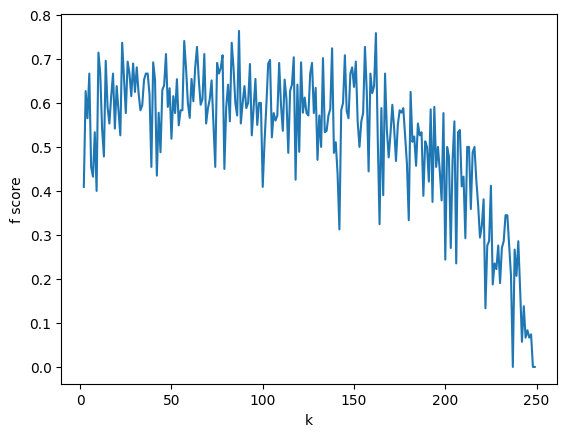

In [31]:
def get_scores(k):
  # Use knn on age. First create a nearest neighbors object.
  nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

  # This builds an index data structure under the hood for query performance
  X = df[['age_s', 'trestbps_s']].values
  fit = nn.fit(X)

  # Get random patients to test on
  n = 50
  patients = df.sample(n)
  patientsX = patients[['age_s','trestbps_s']].values
  patientsy = patients[['disease']].values
  # display(patients)

  # Find the k nearest neighbors to the patient.
  distances, indices = fit.kneighbors(patientsX)
  # print('indices of k-nearest neighbors for each patient:')
  # display(indices)

  y_pred = []
  for i in range(n):
      # print('nearest neighbors to patient: {}:'.format(patientsX[i]))
      nbrs = df.iloc[indices[i]]
      # Drop the patient of interest
      nbrs = nbrs.drop(patients.index[i], errors='ignore')
      # display(nbrs)

      healthy = nbrs[nbrs.disease == 0].count().disease
      sick = nbrs[nbrs.disease == 1].count().disease
      predict = 0 if (healthy > sick) else 1
      # print(f'healthy: {healthy}, sick: {sick}, predicted: {predict}, actual: {patientsy[i][0]}')
      y_pred.append(predict)

  # This is where we would compile how many patients are predicted
  # correctly. Remember:
  #    precision = tp/(tp+fp)  ("sloppiness")
  #    recall    = tp/(tp+fn)  ("What percentage did we find?")
  #    f-score - a balance between precision and recall
  #    support - number of positive labels
  return precision_recall_fscore_support(patientsy, y_pred, labels=[1])

kvals = range(2, 250)
scores = [get_scores(k) for k in kvals]
# print(scores)

scores = [(p[0], r[0], f[0], s[0]) for (p,r,f,s) in scores]
scores = list(zip(*scores))

plt.plot(kvals, scores[2])
plt.xlabel('k')
plt.ylabel('f score')

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

k = 20
nn = NearestNeighbors(n_neighbors=k, metric='euclidean', algorithm='auto')

X = df[['age', 'trestbps', 'chol', 'thalach']].values
y = df[['disease']].values

# Use random_state if you want the same values each time you run for debugging,
# but you should select the split randomly when you're ready to actually train
# and test on the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)#, random_state=42)

display(y_test)
##(p,r,f,s) = precision_recall_fscore_support(y_test, y_pred, labels=[1])

array([[0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1]], dtype=int64)